In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ARMUL/experiments in the paper')
from run_experiment import run_synthetic, run_real


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# synthetic data experiment
idx_model = 1 # index of ARMUL model: 1 for vanilla, 2 for clustered, 3 for low-rank
idx_seed = 10 # index of random seed configuration: from 1 to 10
#run_synthetic(idx_model, idx_seed) # run experiment

# real data experiment
# note: idx_model ranges from 0 to 3: 0 for Independent Task Learning (ITL)
#run_real(idx_model, idx_seed) # run experiment


In [3]:
# summarize and present the results

import numpy as np
import matplotlib.pyplot as plt
import pickle

path_0 = '/content/drive/MyDrive/Colab Notebooks/ARMUL/experiments in the paper'


In [4]:
# Real data

model_list = ['vanilla', 'lowrank', 'clustered', 'ITL', 'DP_base', 'lowrank_base', 'clustered_base']
S1 = set(model_list[0:3])


I, S = 10, 10
seed_list = []
tmp = np.array(range(1, S + 1)) * 10000
for idx in range(I):
    for i in range(S):
        seed_list.append( tmp[i] + idx * 1000 )

ans = dict()

for model in model_list:

    path = path_0 + '/results/real_{}'.format( model )
    results = dict()
    tmp = np.zeros(len(seed_list))

    for (j, seed) in enumerate(seed_list):
        with open(path + '/{}.txt'.format(seed), "rb") as fp:
            results[j] = pickle.load(fp)
        if model in S1:
            tmp[j] = results[j][0][0]['average error']
        else:
            tmp[j] = results[j][0]['average error']

    tmp *= 100

    ans[model] = [np.mean(tmp), np.std(tmp)]

print('Test errors and standard deviations')
print(ans)


Test errors and standard deviations
{'vanilla': [1.1226184660478749, 0.24919106446713163], 'lowrank': [0.7962872496336104, 0.19251646795542773], 'clustered': [0.8353688324377138, 0.21677291384791197], 'ITL': [1.953590620420127, 0.3229034481378435], 'DP_base': [3.4792379091353207, 0.38525476800124064], 'lowrank_base': [1.3023937469467513, 0.2296791238553636], 'clustered_base': [2.1470444553004397, 0.3252511019133582]}


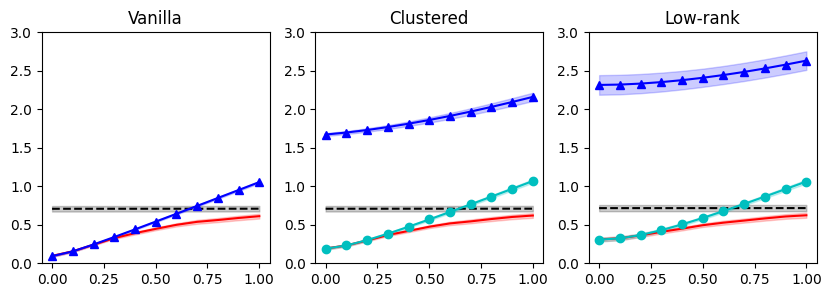

In [6]:
# Simulations

epsilon = 0 # 0 or 0.2
idx_set = 'S' # all or S

setting_list = ['vanilla', 'clustered', 'lowrank']
delta_list = [(i / 10) for i in range(11)]

S = 10
seed_list = []
for idx in range(1, 11):
    tmp = np.array(range(1, S + 1)) * 10000 # random seeds
    for i in range(S):
        seed_list.append( tmp[i] + (idx - 1) * 1000 )
M = len(seed_list)


def plot_curves(fig, mean, sd, lst, marker, color):
    fig.fill_between(lst, mean - sd, mean + sd, alpha = 0.2, color = color)
    fig.plot(lst, mean, marker, color = color)
    fig.set_ylim([0, 3])

fig, axes = plt.subplots(1, 3, figsize = (10, 3))

for (i, setting) in enumerate(setting_list):
    path = path_0 + '/results/synthetic_' + setting
    results = dict()
    results['ARMUL'] = np.zeros((11, M))
    results['STL'] = np.zeros((11, M))
    results['DP'] = np.zeros((11, M))
    results['baseline'] = np.zeros((11, M))

    for (s, seed) in enumerate(seed_list):
        with open(path + '/{}.txt'.format(seed), "rb") as fp:
            lst = pickle.load(fp)

        for (idx_delta, delta) in enumerate(delta_list):
            # max over S
            tmp = lst[(epsilon, delta, idx_set)]
            results['ARMUL'][idx_delta, s] = np.max( np.array(tmp['ARMUL']) )
            results['STL'][idx_delta, s] = np.max( np.array(tmp['STL']) )
            results['DP'][idx_delta, s] = np.max( np.array(tmp['DP']) )
            if setting == 'clustered' or setting == 'lowrank':
                results['baseline'][idx_delta, s] = np.max( np.array(tmp['baseline']) )

    names = ['ARMUL', 'STL', 'DP', 'baseline']
    Mean = dict()
    SD = dict()

    for name in names:
        Mean[name] = np.zeros(11)
        SD[name] = np.zeros(11)
        for j in range(11):
            SD[name][j] = np.std(results[name][j]) #/ np.sqrt( len(results[name][j]) )
            Mean[name][j] = np.mean(results[name][j])

    plot_curves(axes[i], Mean['ARMUL'], SD['ARMUL'], delta_list, marker = '-', color = 'r')
    plot_curves(axes[i], Mean['STL'], SD['STL'], delta_list, marker = '--', color = 'k')
    plot_curves(axes[i], Mean['DP'], SD['DP'], delta_list, marker = '^-', color = 'b')
    if setting == 'clustered' or setting == 'lowrank':
        plot_curves(axes[i], Mean['baseline'], SD['baseline'], delta_list, marker = 'o-', color = 'c')

if epsilon == 0:
    axes[0].set_title('Vanilla')
    axes[1].set_title('Clustered')
    axes[2].set_title('Low-rank')
    fig.savefig( path_0 + '/epsilon_0.pdf', format = 'pdf')
else: # epsilon == 0.2
    if idx_set == 'S':
        axes[0].set_title('Vanilla (S)')
        axes[1].set_title('Clustered (S)')
        axes[2].set_title('Low-rank (S)')
        fig.savefig(path_0 + '/epsilon_2_S.pdf', format = 'pdf')
    else: # idx_set == 'all'
        axes[0].set_title('Vanilla (all)')
        axes[1].set_title('Clustered (all)')
        axes[2].set_title('Low-rank (all)')
        fig.savefig(path_0 + '/epsilon_2_all.pdf', format = 'pdf')


